In [3]:
from google.colab import drive
import os

# Check if the drive is already mounted
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Drive already mounted at /content/drive")

Drive already mounted at /content/drive


In [4]:
import os
import glob
import nibabel as nib
import numpy as np
import tensorflow as tf
import tarfile
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
# Path to the uploaded tar file
tar_file_path = '/content/drive/MyDrive/Copy of Task01_BrainTumour.tar'

# Directory where you want to extract the files
extracted_dir = '/content/drive/MyDrive/MSD_brain'

# Create the directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

In [6]:
# Extract the tar file
with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall(path=extracted_dir)

print(f"Files extracted to {extracted_dir}")

Files extracted to /content/drive/MyDrive/MSD_brain


In [7]:
# List the contents of the extracted directory
print("Extracted directory contents:")
print(os.listdir(extracted_dir))

# Check the contents of imagesTr and labelsTr directories
images_dir = os.path.join(extracted_dir,'Task01_BrainTumour', 'imagesTr')
labels_dir = os.path.join(extracted_dir,'Task01_BrainTumour', 'labelsTr')

print("\nimagesTr directory contents:")
print(os.listdir(images_dir))

print("\nlabelsTr directory contents:")
print(os.listdir(labels_dir))

Extracted directory contents:
['Task01_BrainTumour']

imagesTr directory contents:
['BRATS_457.nii.gz', 'BRATS_306.nii.gz', 'BRATS_206.nii.gz', 'BRATS_449.nii.gz', 'BRATS_318.nii.gz', 'BRATS_218.nii.gz', 'BRATS_434.nii.gz', 'BRATS_365.nii.gz', 'BRATS_265.nii.gz', 'BRATS_214.nii.gz', 'BRATS_314.nii.gz', 'BRATS_445.nii.gz', 'BRATS_269.nii.gz', 'BRATS_369.nii.gz', 'BRATS_438.nii.gz', 'BRATS_277.nii.gz', 'BRATS_377.nii.gz', 'BRATS_426.nii.gz', 'BRATS_095.nii.gz', 'BRATS_222.nii.gz', 'BRATS_195.nii.gz', 'BRATS_473.nii.gz', 'BRATS_322.nii.gz', 'BRATS_241.nii.gz', 'BRATS_410.nii.gz', 'BRATS_341.nii.gz', 'BRATS_330.nii.gz', 'BRATS_461.nii.gz', 'BRATS_187.nii.gz', 'BRATS_230.nii.gz', 'BRATS_087.nii.gz', 'BRATS_199.nii.gz', 'BRATS_099.nii.gz', 'BRATS_353.nii.gz', 'BRATS_402.nii.gz', 'BRATS_253.nii.gz', 'BRATS_384.nii.gz', 'BRATS_133.nii.gz', 'BRATS_284.nii.gz', 'BRATS_033.nii.gz', 'BRATS_150.nii.gz', 'BRATS_050.nii.gz', 'BRATS_021.nii.gz', 'BRATS_296.nii.gz', 'BRATS_121.nii.gz', 'BRATS_396.nii.g

In [8]:
print("Extracted directory contents:")
print(os.listdir(extracted_dir))

Extracted directory contents:
['Task01_BrainTumour']


In [9]:
# Check the contents of imagesTr and labelsTr directories
images_dir = os.path.join(extracted_dir, 'Task01_BrainTumour', 'imagesTr')
labels_dir = os.path.join(extracted_dir, 'Task01_BrainTumour', 'labelsTr')

In [10]:
print("\nimagesTr directory contents:")
print(os.listdir(images_dir)[:10])  # Show only first 10 files

print("\nlabelsTr directory contents:")
print(os.listdir(labels_dir)[:10])  # Show only first 10 files


imagesTr directory contents:
['BRATS_457.nii.gz', 'BRATS_306.nii.gz', 'BRATS_206.nii.gz', 'BRATS_449.nii.gz', 'BRATS_318.nii.gz', 'BRATS_218.nii.gz', 'BRATS_434.nii.gz', 'BRATS_365.nii.gz', 'BRATS_265.nii.gz', 'BRATS_214.nii.gz']

labelsTr directory contents:
['BRATS_457.nii.gz', 'BRATS_306.nii.gz', 'BRATS_206.nii.gz', 'BRATS_449.nii.gz', 'BRATS_318.nii.gz', 'BRATS_218.nii.gz', 'BRATS_434.nii.gz', 'BRATS_365.nii.gz', 'BRATS_265.nii.gz', 'BRATS_214.nii.gz']


In [11]:
# Step 3: Preprocess and Load the Dataset
# Function to load and preprocess the NIfTI images
#def load_nifti_file(filepath):
#    img = nib.load(filepath)
#    img_data = img.get_fdata()
#    return img_data


In [12]:
def load_nifti_file(filepath):
    try:
        img = nib.load(filepath)
        img_data = img.get_fdata()
        print(f"Loaded {filepath} with shape {img_data.shape}")
        return img_data
    except nib.filebasedimages.ImageFileError as e:
        print(f"Skipping invalid file: {filepath}")
        return None

In [13]:
def preprocess(image, label):
    # Select a slice and a channel
    image = image[:, :, 80, 0]  # Example: slice 80, channel 0
    label = label[:, :, 80]     # Example: slice 80

    if image.ndim == 2:  # Add channel dimension if missing
        image = tf.expand_dims(image, -1)
    if label.ndim == 2:  # Add channel dimension if missing
        label = tf.expand_dims(label, -1)

    print(f"Preprocessing image with shape {image.shape} and label with shape {label.shape}")

    image = tf.image.resize(image, (128, 128))  # Resize the image
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image
    label = tf.image.resize(label, (128, 128))  # Resize the label
    label = tf.cast(label, tf.float32)
    return image, label

In [14]:
# Function to create a TensorFlow dataset
#def create_tf_dataset(images_dir, labels_dir):
#    image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.nii.gz') and not f.startswith('._')])
#    label_files = sorted([os.path.join(labels_dir, f) for f in os.listdir(labels_dir) if f.endswith('.nii.gz') and not f.startswith('._')])

#    images = []
#    labels = []

#    for img_file, lbl_file in zip(image_files, label_files):
#        img = load_nifti_file(img_file)
#        lbl = load_nifti_file(lbl_file)
#        if img is not None and lbl is not None:
#            images.append(img)
#            labels.append(lbl)

#    images = np.expand_dims(images, axis=-1)  # Add channel dimension
#    labels = np.expand_dims(labels, axis=-1)  # Add channel dimension

#    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
#    dataset = dataset.map(lambda x, y: preprocess(x, y), num_parallel_calls=tf.data.AUTOTUNE)
#    return dataset

In [15]:
def create_tf_dataset(images_dir, labels_dir, test_size=0.2):
    # Select only 10 files
    image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.nii.gz') and not f.startswith('._')])[:7]
    label_files = sorted([os.path.join(labels_dir, f) for f in os.listdir(labels_dir) if f.endswith('.nii.gz') and not f.startswith('._')])[:7]

    images = []
    labels = []

    for img_file, lbl_file in zip(image_files, label_files):
        img = load_nifti_file(img_file)
        lbl = load_nifti_file(lbl_file)
        if img is not None and lbl is not None:
            images.append(img)
            labels.append(lbl)

    images = np.array(images)
    labels = np.array(labels)

    # Split the data into training and testing sets (Updated)
    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=test_size, random_state=42)

    # Convert to TensorFlow datasets (Updated)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_dataset = train_dataset.map(lambda x, y: preprocess(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    test_dataset = test_dataset.map(lambda x, y: preprocess(x, y), num_parallel_calls=tf.data.AUTOTUNE)

    return train_dataset, test_dataset, test_images, test_labels

In [16]:
# Create the TensorFlow datasets
train_dataset, test_dataset, test_images, test_labels = create_tf_dataset(images_dir, labels_dir)

Loaded /content/drive/MyDrive/MSD_brain/Task01_BrainTumour/imagesTr/BRATS_001.nii.gz with shape (240, 240, 155, 4)
Loaded /content/drive/MyDrive/MSD_brain/Task01_BrainTumour/labelsTr/BRATS_001.nii.gz with shape (240, 240, 155)
Loaded /content/drive/MyDrive/MSD_brain/Task01_BrainTumour/imagesTr/BRATS_002.nii.gz with shape (240, 240, 155, 4)
Loaded /content/drive/MyDrive/MSD_brain/Task01_BrainTumour/labelsTr/BRATS_002.nii.gz with shape (240, 240, 155)
Loaded /content/drive/MyDrive/MSD_brain/Task01_BrainTumour/imagesTr/BRATS_003.nii.gz with shape (240, 240, 155, 4)
Loaded /content/drive/MyDrive/MSD_brain/Task01_BrainTumour/labelsTr/BRATS_003.nii.gz with shape (240, 240, 155)
Loaded /content/drive/MyDrive/MSD_brain/Task01_BrainTumour/imagesTr/BRATS_004.nii.gz with shape (240, 240, 155, 4)
Loaded /content/drive/MyDrive/MSD_brain/Task01_BrainTumour/labelsTr/BRATS_004.nii.gz with shape (240, 240, 155)
Loaded /content/drive/MyDrive/MSD_brain/Task01_BrainTumour/imagesTr/BRATS_005.nii.gz with sh

In [17]:
# Batch and prefetch the dataset for performance
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
def conv_block(x, filters, kernel_size=3, activation='relu', padding='same'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
    return x

def encoder(x, filters, kernel_size=3, activation='relu', padding='same', pool_size=(2,2)):
    x = conv_block(x, filters, kernel_size, activation, padding)
    p = tf.keras.layers.MaxPool2D(pool_size)(x)
    return x, p

def decoder(x, skip_connection, filters, kernel_size=3, activation='relu',padding='same', up_size=(2,2)):
    x = tf.keras.layers.UpSampling2D(up_size)(x)
    x = tf.keras.layers.Concatenate()([x, skip_connection])
    x = conv_block(x, filters, kernel_size, activation, padding)
    return x

def unet(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    # Encoder
    s1, p1 = encoder(inputs, 64)
    s2, p2 = encoder(p1, 128)
    s3, p3 = encoder(p2, 256)
    s4, p4 = encoder(p3, 512)

    # Bottleneck
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder(b1, s4, 512)
    d2 = decoder(d1, s3, 256)
    d3 = decoder(d2, s2, 128)
    d4 = decoder(d3, s1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(d4)

    model = tf.keras.Model(inputs, outputs)
    return model

In [19]:
input_shape = (128,128,1)
model = unet(input_shape)

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 37s 37s/step - accuracy: 0.2128 - loss: 0.6941 - val_accuracy: 0.9711 - val_loss: 0.5539
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.9557 - loss: 0.6190 - val_accuracy: 0.9711 - val_loss: 115.5391
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.9557 - loss: 221.1711 - val_accuracy: 0.9711 - val_loss: 0.4497
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9557 - loss: 0.4988 - val_accuracy: 0.9711 - val_loss: 0.6597
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9557 - loss: 0.6662 - val_accuracy: 0.9711 - val_loss: 0.6593
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9557 - loss: 0.6647 - val_accuracy: 0.9711 - val_loss: 0.6496
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9557 - loss: 0.6562 - val_accuracy: 0.9711 - val_loss: 0.6257
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9557 - loss: 0.6364 - val_accuracy: 0.9711 -

In [22]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9175 - loss: 0.1609
Test accuracy: 0.917510986328125


In [23]:
train_loss, train_accuracy = model.evaluate(train_dataset)
print(f"Train accuracy: {train_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.9100 - loss: 0.0929
Train accuracy: 0.910021960735321


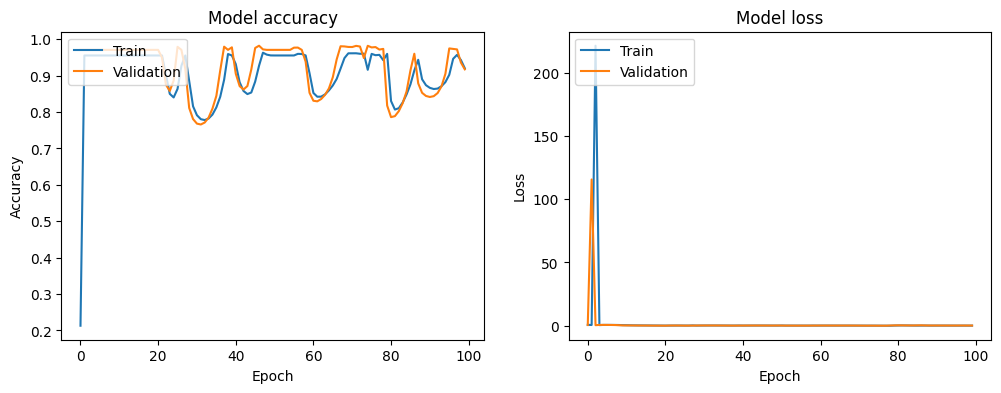

In [24]:
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [25]:
selected_image = test_images[0][:, :, 80, 0]  # Example: slice 80, channel 0
selected_image = np.expand_dims(selected_image, axis=-1)  # Add channel dimension

In [26]:
# Preprocess the selected image (Updated)
preprocessed_image = tf.image.resize(selected_image, (128, 128))
preprocessed_image = tf.cast(preprocessed_image, tf.float32) / 255.0
preprocessed_image = tf.expand_dims(preprocessed_image, axis=0)  # Add batch dimension

In [27]:
# Predict the segmentation mask for the selected image (Updated)
predicted_mask = model.predict(preprocessed_image)
predicted_mask = predicted_mask[0, :, :, 0]  # Remove batch and channel dimensions

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


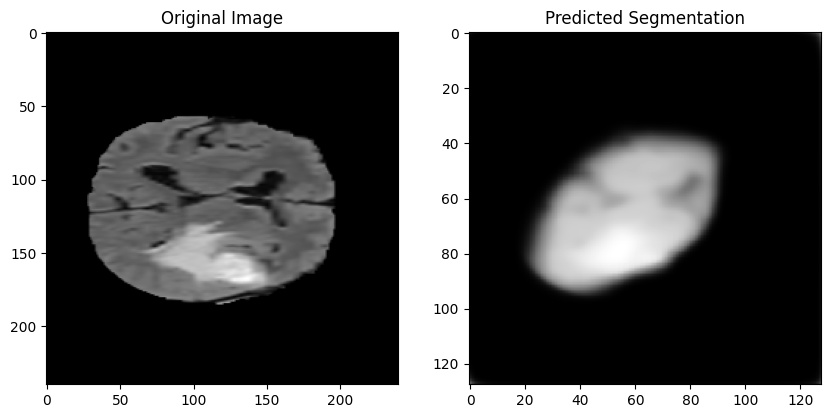

In [28]:
# Plot the original image and the predicted segmentation mask (Updated)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(selected_image[:, :, 0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Predicted Segmentation")
plt.imshow(predicted_mask, cmap='gray')

plt.show()